# Generate pressure coefficients

The following steps are performed to obtain all the artifacts for pressure coefficient use case:

1. Read parameters file
2. Read Mesh description
   * Its path can be specified
   * Or it can be obtained from the simulation configuration file
3. Read data
   * For reference static pressure
   * For body pressure data
   * Slice from timestep range specified
4. Transform pressure data into pressure coefficient
5. Calculate pressure coefficient statistics
6. Merge coefficient statistics with mesh description into VTK
  
  

Initialize Path Manager

In [1]:
from cfdmod.use_cases.pressure.path_manager import CpPathManager, copy_input_artifacts
import pathlib

path_manager = CpPathManager(output_path=pathlib.Path("./output/pressure"))

Read post-processing Cp config file

In [2]:
from cfdmod.use_cases.pressure.cp_config import CpCaseConfig

cfg_path = pathlib.Path("./fixtures/tests/pressure/cp_params.yaml")
post_proc_cfg = CpCaseConfig.from_file(cfg_path)
cfg = post_proc_cfg.pressure_coefficient["default"]

post_proc_cfg

CpCaseConfig(pressure_coefficient={'default': CpConfig(timestep_range=(10000.0, 20000.0), reference_pressure='average', U_H=0.05, U_H_correction_factor=1, statistics=['min', 'max', 'std', 'mean', 'skewness', 'kurtosis', 'xtr_min', 'xtr_max'])}, extreme_values=ExtremeValuesParameters(CST_real=0.56, CST_sim=16.89, t=3.0, T0=60.0, T1=600.0, yR=1.4))

Read LNAS Mesh

In [3]:
from lnas import LnasFormat

mesh_path = pathlib.Path("./fixtures/tests/pressure/galpao/galpao.lnas")
mesh = LnasFormat.from_file(mesh_path)

mesh.name, mesh.geometry.vertices.shape, mesh.geometry.triangles.shape

('galpao', (1549, 3), (2915, 3))

Read hist series and slice from the time range

In [4]:
from cfdmod.use_cases.pressure.cp_data import filter_pressure_data
import pandas as pd

static_data_path = pathlib.Path(
    "./fixtures/tests/pressure/data/points.static_pressure.data.resampled.h5"
)
body_data_path = pathlib.Path("./fixtures/tests/pressure/data/bodies.galpao.data.resampled.h5")

press_data: pd.DataFrame = pd.read_hdf(static_data_path)  # type: ignore
body_data: pd.DataFrame = pd.read_hdf(body_data_path)  # type: ignore

press_data, body_data = filter_pressure_data(press_data, body_data, cfg.timestep_range)

press_data, body_data

(      point_idx       rho  time_step
 2915          0  1.002515    10000.0
 2915          0  1.002532    10001.0
 2915          0  1.002549    10002.0
 2915          0  1.002566    10003.0
 2915          0  1.002583    10004.0
 ...         ...       ...        ...
 2915          0  1.003020    10096.0
 2915          0  1.003010    10097.0
 2915          0  1.002998    10098.0
 2915          0  1.002987    10099.0
 2915          0  1.002974    10100.0
 
 [101 rows x 3 columns],
       point_idx       rho  time_step
 0             0  1.001819    10000.0
 1             1  1.001838    10000.0
 2             2  1.001808    10000.0
 3             3  1.001851    10000.0
 4             4  1.001835    10000.0
 ...         ...       ...        ...
 2910       2910  1.002633    10100.0
 2911       2911  1.002594    10100.0
 2912       2912  1.002504    10100.0
 2913       2913  1.002828    10100.0
 2914       2914  1.002812    10100.0
 
 [294415 rows x 3 columns])

Transform pressure data into coefficient

In [5]:
from cfdmod.use_cases.pressure.cp_data import transform_to_cp
import numpy as np

cp_data = transform_to_cp(
    press_data,
    body_data,
    reference_vel=cfg.U_H,
    ref_press_mode=cfg.reference_pressure,
    correction_factor=cfg.U_H_correction_factor,
)

cp_data

,time_step,point_idx,cp
0,10000.0,0,-0.311587
1,10000.0,1,-0.306326
2,10000.0,2,-0.314535
3,10000.0,3,-0.302966
4,10000.0,4,-0.307277
...,...,...,...
294410,10100.0,2910,-0.094988
294411,10100.0,2911,-0.105542
294412,10100.0,2912,-0.129440
294413,10100.0,2913,-0.043326


In [9]:
from cfdmod.use_cases.pressure.extreme_values import ExtremeValuesParameters, calculate_extreme_values
from matplotlib import pyplot as plt

params = ExtremeValuesParameters(
    CST_real=0.56,
    CST_sim=16.89,
    t = 0.5,  # (s), duracao do evento extremo
    T0 = 0.6,  # (s) actual observation period
    T1 = 6,  # (s) target observation period
    yR = 1.4, 
)
series = pd.read_csv("./fixtures/tests/serie_hist_ponto_do_telhado_separacao.csv", delimiter=",").to_numpy()
# timestep = series[:, 0]
# parent_cp = series[:, 2]
timestep = np.unique(cp_data.time_step.to_numpy())
parent_cp = cp_data.loc[cp_data["point_idx"] == 0].cp.to_numpy()
calculate_extreme_values(params=params, timestep_arr=timestep, hist_series=parent_cp)
# time, new_time, smooth_parent_cp = calculate_extreme_values(params=params, timestep_arr=timestep, hist_series=parent_cp)
# parent_cp.min(), parent_cp.max()

group_by_point = cp_data.groupby("point_idx")
var = "cp"

statistics_data = pd.DataFrame({"point_idx": cp_data["point_idx"].unique()})
average = group_by_point[var].apply(lambda x: calculate_extreme_values(params=params, timestep_arr=timestep, hist_series=x)).reset_index(name="extreme_values")
# statistics_data[f"{var}_extreme_values"] = average["extreme_values"]
# statistics_data[['cp_extreme_values_min', 'cp_extreme_values_max']] = statistics_data['cp_extreme_values'].apply(lambda x: pd.Series(x))
statistics_data[['cp_extreme_values_min', 'cp_extreme_values_max']] = average["extreme_values"].apply(lambda x: pd.Series(x))
# statistics_data = statistics_data.drop('cp_extreme_values', axis=1)

statistics_data

,point_idx,cp_extreme_values_min,cp_extreme_values_max
0,0,-0.528445,0.291392
1,1,-0.524230,0.297746
2,2,-0.531617,0.291137
3,3,-0.520588,0.298339
4,4,-0.525097,0.296380
...,...,...,...
2910,2910,-0.666311,0.130073
2911,2911,-0.510155,0.063363
2912,2912,-0.530702,0.038990
2913,2913,-0.771870,0.248984


-0.6892896109780232 0.48775980164864813


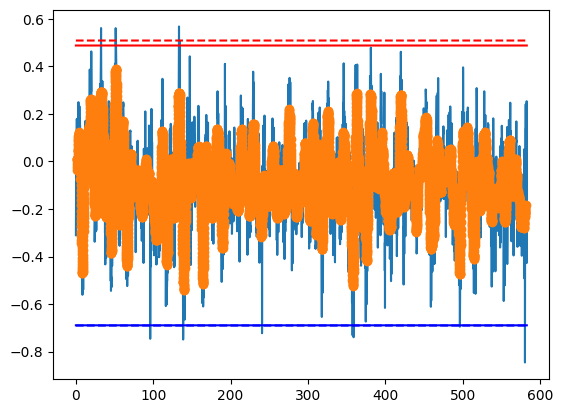

In [7]:
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# parametros de escala
CST_real = 0.56  # (s)
CST_sim = 16.89  # (lbm)

# parametros estatísticos
t = 3  # (s), duracao do evento extremo
T0 = 60  # (s) actual observation period
T1 = 600  # (s) target observation period
yR = 1.4  # variável reduzida correspondente a 78% de probabilidade de não-excedência

# 0 - load temporal cp data
series = pd.read_csv("./fixtures/tests/serie_hist_ponto_do_telhado_separacao.csv", delimiter=",").to_numpy()
timestep = series[:, 0]
parent_cp = series[:, 2]
time = [(timestep[i] - timestep[0]) * (CST_real / CST_sim) for i in range(len(timestep))]

# 1 - make moving average with window size equivalent to max event duration
window_size = int(t / (time[1] - time[0]))
smooth_parent_cp = np.convolve(parent_cp, np.ones(window_size) / window_size, mode="valid")
new_time = time[window_size // 2 - 2 : -window_size // 2 - 1]

# 2 - make sets of same observation period
N = int(round((new_time[-1] - new_time[0]) / T0))  # num_divisions
sub_arrays = np.array_split(smooth_parent_cp, N)

# 3 - get the extreme values
cp_max = np.array([])
cp_min = np.array([])
for sub_arr in sub_arrays:
    cp_max = np.append(cp_max, np.max(sub_arr))
    cp_min = np.append(cp_min, np.min(sub_arr))
cp_max = np.sort(cp_max)  ######################
cp_min = np.sort(cp_min)[::-1]  ################

# 4 - Gumbel model for the maximum extreme value
y = [-math.log(-math.log(i / (N + 1))) for i in range(1, N + 1)]
A = np.vstack([y, np.ones(len(y))]).T
a_inv, U_T0 = np.linalg.lstsq(A, cp_max, rcond=None)[0]
U_T1 = U_T0 + a_inv * math.log(T1 / T0)
max_extreme_val = a_inv * yR + U_T1  # This is the design value

# 5 - Gumbel model for the minimum extreme value
y = [-math.log(-math.log(i / (N + 1))) for i in range(1, N + 1)]
A = np.vstack([y, np.ones(len(y))]).T
a_inv, U_T0 = np.linalg.lstsq(A, cp_min, rcond=None)[0]
U_T1 = U_T0 + a_inv * math.log(T1 / T0)
min_extreme_val = a_inv * yR + U_T1  # This is the design value

# plot
print(min_extreme_val, max_extreme_val)
fig, ax = plt.subplots()
ax.plot(time, parent_cp)
ax.plot(new_time, smooth_parent_cp, marker="o", ls="None")
ax.plot(time, [max_extreme_val for i in range(len(time))], color="red")
ax.plot(
    time,
    [np.mean(smooth_parent_cp) + 3.9 * np.std(smooth_parent_cp) for i in range(len(time))],
    color="red",
    ls="--",
)
ax.plot(time, [min_extreme_val for i in range(len(time))], color="blue")
ax.plot(
    time,
    [np.mean(smooth_parent_cp) - 3.9 * np.std(smooth_parent_cp) for i in range(len(time))],
    color="blue",
    ls="--",
)
# plt.hist(smooth_parent_cp, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.show()


Calculate pressure coefficient statistics

In [8]:
from cfdmod.use_cases.pressure.cp_data import calculate_statistics

cp_stats = calculate_statistics(cp_data, statistics_to_apply=cfg.statistics)

cp_stats

TypeError: calculate_statistics() missing 1 required positional argument: 'extreme_params'

Combine statistics with mesh and create a VTK object

In [ ]:
from cfdmod.api.vtk.write_vtk import write_polydata, create_polydata_for_cell_data

polydata = create_polydata_for_cell_data(data=cp_stats, mesh=mesh.geometry)

# OUTPUT 3: VTK cp_stats
write_polydata(path_manager.vtp_path, polydata)

Copy Input artifacts to output folder

In [ ]:
copy_input_artifacts(
    cfg_path=cfg_path,
    mesh_path=mesh_path,
    static_data_path=static_data_path,
    body_data_path=body_data_path,
    path_manager=path_manager,
)